<a href="https://colab.research.google.com/github/hertie-data-science-lab/tutorial-new-group-2-1/blob/xiaohan-modeling/tutorial_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Transfer Learning for Flood Mapping Using Sentinel-1 Radar Imagery


# GRAD-E1394 Deep Learning - Assignment 3

Authors:


*   Aditi Joshi
*   Elena Murray
*   Leticia Figueiredo Collado
*   Sattiki Ganguly
*   Xiaohan Wu







Test - check commit.

In [3]:
!pip install segmentation-models-pytorch --quiet
!pip install pretrainedmodels --quiet
!pip install efficientnet-pytorch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [4]:
!gsutil ls gs://sen1floods11/v1.1/catalog/sen1floods11_hand_labeled_label/ > chip_list.txt

with open("chip_list.txt") as f:
    chip_dirs = [line.strip() for line in f]

chip_dirs = [d for d in chip_dirs if d.endswith("_label/")]

def parse_chip(d):
    name = d.rstrip("/").split("/")[-1].replace("_label", "")
    country = name.split("_")[0]
    return country, name

chip_info = [parse_chip(d) for d in chip_dirs]

In [5]:
# Count chips per country
from collections import Counter
country_counts = Counter([country for country, _ in chip_info])

print("Chips per country:")
for country, count in sorted(country_counts.items(), key=lambda x: -x[1])[:10]:
    print(f"  {country}: {count}")

Chips per country:
  USA: 69
  India: 68
  Paraguay: 67
  Ghana: 53
  Sri-Lanka: 42
  Mekong: 30
  Spain: 30
  Pakistan: 28
  Somalia: 26
  Nigeria: 18


In [6]:
target_per_country = 50
selected_countries = ["India", "USA", "Paraguay"]

selected_chips = []
for country in selected_countries:
    country_chips = [name for c, name in chip_info if c == country]
    # Take up to target_per_country from each
    selected_chips.extend(country_chips[:target_per_country])

print(f"\nSelected {len(selected_chips)} chips from {len(selected_countries)} countries")
print(f"Target: ~150 chips for balanced dataset")


Selected 150 chips from 3 countries
Target: ~150 chips for balanced dataset


In [7]:
import torch
import numpy as np
import rasterio
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms.functional as F
import torchvision.transforms as T
import random

# GCS streaming prefixes
HTTP_PREFIX = "https://storage.googleapis.com/sen1floods11/v1.1"
S1_PREFIX    = f"/vsicurl/{HTTP_PREFIX}/data/flood_events/HandLabeled/S1Hand"
LABEL_PREFIX = f"/vsicurl/{HTTP_PREFIX}/data/flood_events/HandLabeled/LabelHand"

class Sentinel1FloodDataset(Dataset):
    def __init__(self, id_list, augment = False):
        self.ids = id_list
        self.augment = augment

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        cid = self.ids[idx]

        s1_path    = f"{S1_PREFIX}/{cid}_S1Hand.tif"
        label_path = f"{LABEL_PREFIX}/{cid}_LabelHand.tif"

        # --- Load Sentinel-1 SAR image (VV/VH) ---
        with rasterio.open(s1_path) as src:
            s1_img = src.read().astype("float32")  # (2, 512, 512)

        # Robust SAR normalization
        s1_img = np.nan_to_num(s1_img)
        s1_img = np.clip(s1_img, -50, 50)
        s1_img = np.log1p(s1_img - s1_img.min())
        s1_img = (s1_img - s1_img.mean()) / (s1_img.std() + 1e-6)

        # --- Load flood mask ---
        with rasterio.open(label_path) as src:
            mask_raw = src.read(1).astype("int16")

        valid_mask = (mask_raw != -1)
        label = (mask_raw == 1).astype("float32")

        # Data augmentation
        if self.augment:
            if random.random() > 0.5:
                s1_img = np.flip(s1_img, axis=2).copy()
                label = np.flip(label, axis=1).copy()
                valid_mask = np.flip(valid_mask, axis=1).copy()

            if random.random() > 0.5:
                s1_img = np.flip(s1_img, axis=1).copy()
                label = np.flip(label, axis=0).copy()
                valid_mask = np.flip(valid_mask, axis=0).copy()

            k = random.randint(0, 3)
            if k > 0:
                s1_img = np.rot90(s1_img, k, axes=(1, 2)).copy()
                label = np.rot90(label, k, axes=(0, 1)).copy()
                valid_mask = np.rot90(valid_mask, k, axes=(0, 1)).copy()

        x = torch.tensor(s1_img, dtype=torch.float32)
        y = torch.tensor(label, dtype=torch.float32)[None, ...]
        valid = torch.tensor(valid_mask, dtype=torch.bool)[None, ...]

        return x, y, valid

In [8]:
def tensor_to_pil_pair(x, y, valid):
    vv = x[0].cpu().numpy()
    vh = x[1].cpu().numpy()
    label_arr = y[0].cpu().numpy()
    valid_arr = valid[0].cpu().numpy().astype(np.uint8)

    # Normalize to 0-255 range for visualization
    vv_norm = ((vv - vv.min()) / (vv.max() - vv.min() + 1e-8) * 255).astype(np.uint8)
    vh_norm = ((vh - vh.min()) / (vh.max() - vh.min() + 1e-8) * 255).astype(np.uint8)

    vv_pil = Image.fromarray(vv_norm)
    vh_pil = Image.fromarray(vh_norm)
    label_pil = Image.fromarray((label_arr * 255).astype(np.uint8))
    valid_pil = Image.fromarray((valid_arr * 255).astype(np.uint8))

    return vv_pil, vh_pil, label_pil, valid_pil

In [9]:
def preprocess_test(x, y, valid):
    return x, y, valid

In [10]:
valid_ids = sorted(selected_chips)

np.random.seed(42)
np.random.shuffle(valid_ids)

n = len(valid_ids)
train_ids = valid_ids[:int(0.7*n)]
val_ids   = valid_ids[int(0.7*n):int(0.85*n)]
test_ids  = valid_ids[int(0.85*n):]

print(f"Train: {len(train_ids)}  Val: {len(val_ids)}  Test: {len(test_ids)}")

Train: 105  Val: 22  Test: 23


In [11]:
batch_size = 4

train_ds = Sentinel1FloodDataset(train_ids, augment=True)
val_ds   = Sentinel1FloodDataset(val_ids,   augment=False)
test_ds  = Sentinel1FloodDataset(test_ids,  augment=False)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

In [12]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

# U-Net with ResNet34 encoder pre-trained on ImageNet  ← TRANSFER LEARNING
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",   # this is the transfer part
    in_channels=2,                # VV + VH
    classes=1                     # binary mask
).to(device)

# Binary cross entropy with logits loss
# Combines sigmoid activation + BCE loss for numerical stability
criterion = nn.BCEWithLogitsLoss()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [13]:
def compute_iou_from_logits(logits, target, valid):
    """
    Compute Intersection over Union (IoU) for flood segmentation.

    Args:
        logits: (B,1,H,W) - raw model outputs (before sigmoid)
        target: (B,1,H,W) - ground truth labels (0/1)
        valid:  (B,1,H,W) - validity mask (True for valid pixels)

    Returns:
        iou: scalar tensor - IoU score
    """
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()

    v = valid.bool()
    if v.sum() == 0:
        return torch.tensor(0.0, device=logits.device)

    p = preds[v]
    t = target[v]

    intersection = (p * t).sum()
    union = p.sum() + t.sum() - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou


def compute_accuracy_from_logits(logits, target, valid):
    """
    Compute pixel-wise accuracy for flood segmentation.

    Args:
        logits: (B,1,H,W) - raw model outputs (before sigmoid)
        target: (B,1,H,W) - ground truth labels (0/1)
        valid:  (B,1,H,W) - validity mask (True for valid pixels)

    Returns:
        acc: scalar tensor - accuracy score
    """
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()

    v = valid.bool()
    if v.sum() == 0:
        return torch.tensor(0.0, device=logits.device)

    p = preds[v]
    t = target[v]

    correct = (p == t).float().sum()
    acc = correct / p.numel()
    return acc

In [14]:
def train_one_epoch(model, dl, optimizer):
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    total_acc = 0.0
    n_batches = 0

    for x, y, valid in dl:
        x = x.to(device)
        y = y.to(device)
        valid = valid.to(device)

        optimizer.zero_grad()
        logits = model(x)  # (B,1,H,W)

        if valid.sum() == 0:
            continue

        loss = criterion(logits[valid], y[valid])
        loss.backward()
        optimizer.step()

        iou = compute_iou_from_logits(logits, y, valid).item()
        acc = compute_accuracy_from_logits(logits, y, valid).item()

        total_loss += loss.item()
        total_iou  += iou
        total_acc  += acc
        n_batches  += 1

    if n_batches == 0:
        return 0.0, 0.0, 0.0

    return (
        total_loss / n_batches,
        total_iou  / n_batches,
        total_acc  / n_batches,
    )


@torch.no_grad()
def validate_one_epoch(model, dl):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    total_acc = 0.0
    n_batches = 0

    for x, y, valid in dl:
        x = x.to(device)
        y = y.to(device)
        valid = valid.to(device)

        logits = model(x)

        if valid.sum() == 0:
            continue

        loss = criterion(logits[valid], y[valid])
        iou = compute_iou_from_logits(logits, y, valid).item()
        acc = compute_accuracy_from_logits(logits, y, valid).item()

        total_loss += loss.item()
        total_iou  += iou
        total_acc  += acc
        n_batches  += 1

    if n_batches == 0:
        return 0.0, 0.0, 0.0

    return (
        total_loss / n_batches,
        total_iou  / n_batches,
        total_acc  / n_batches,
    )

In [15]:
# Freeze encoder → only train decoder/head (classic transfer learning warmup)
for p in model.encoder.parameters():
    p.requires_grad = False

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
)

print("=== Stage 1: Train Decoder Only (Frozen Encoder) ===")
num_epochs_stage1 = 3

for epoch in range(num_epochs_stage1):
    tr_loss, tr_iou, tr_acc = train_one_epoch(model, train_dl, optimizer)
    va_loss, va_iou, va_acc = validate_one_epoch(model, val_dl)

    print(f"Epoch {epoch+1}/{num_epochs_stage1}")
    print(f"  Train - Loss: {tr_loss:.4f}, IoU: {tr_iou:.4f}, Acc: {tr_acc:.4f}")
    print(f"  Val   - Loss: {va_loss:.4f}, IoU: {va_iou:.4f}, Acc: {va_acc:.4f}")

=== Stage 1: Train Decoder Only (Frozen Encoder) ===
Epoch 1/3
  Train - Loss: 0.3170, IoU: 0.2802, Acc: 0.9148
  Val   - Loss: 0.1932, IoU: 0.4094, Acc: 0.9401
Epoch 2/3
  Train - Loss: 0.1909, IoU: 0.2830, Acc: 0.9381
  Val   - Loss: 0.1592, IoU: 0.4326, Acc: 0.9538
Epoch 3/3
  Train - Loss: 0.1873, IoU: 0.3006, Acc: 0.9344
  Val   - Loss: 0.1565, IoU: 0.4087, Acc: 0.9527


In [16]:
# ===== STAGE 2: Fine-tune Entire Model =====
# Unfreeze encoder for better SAR adaptation
for p in model.encoder.parameters():
    p.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Lower LR

print("===STAGE 2: Fine-tune Entire Model (Unfrozen Encoder)===")
num_epochs_stage2 = 10

for epoch in range(num_epochs_stage2):
    tr_loss, tr_iou, tr_acc = train_one_epoch(model, train_dl, optimizer)
    va_loss, va_iou, va_acc = validate_one_epoch(model, val_dl)

    print(f"Epoch {epoch+1}/{num_epochs_stage2}")
    print(f"  Train - Loss: {tr_loss:.4f}, IoU: {tr_iou:.4f}, Acc: {tr_acc:.4f}")
    print(f"  Val   - Loss: {va_loss:.4f}, IoU: {va_iou:.4f}, Acc: {va_acc:.4f}")

===STAGE 2: Fine-tune Entire Model (Unfrozen Encoder)===
Epoch 1/10
  Train - Loss: 0.1729, IoU: 0.2842, Acc: 0.9368
  Val   - Loss: 0.1415, IoU: 0.4038, Acc: 0.9544
Epoch 2/10
  Train - Loss: 0.1596, IoU: 0.3407, Acc: 0.9443
  Val   - Loss: 0.1399, IoU: 0.4572, Acc: 0.9567
Epoch 3/10
  Train - Loss: 0.1538, IoU: 0.3629, Acc: 0.9466
  Val   - Loss: 0.1809, IoU: 0.2712, Acc: 0.9444
Epoch 4/10
  Train - Loss: 0.1441, IoU: 0.3725, Acc: 0.9489
  Val   - Loss: 0.1420, IoU: 0.4378, Acc: 0.9553
Epoch 5/10
  Train - Loss: 0.1400, IoU: 0.4219, Acc: 0.9518
  Val   - Loss: 0.1472, IoU: 0.4119, Acc: 0.9560
Epoch 6/10
  Train - Loss: 0.1540, IoU: 0.3759, Acc: 0.9433
  Val   - Loss: 0.1614, IoU: 0.3841, Acc: 0.9521
Epoch 7/10
  Train - Loss: 0.1405, IoU: 0.4006, Acc: 0.9497
  Val   - Loss: 0.1617, IoU: 0.3836, Acc: 0.9513
Epoch 8/10
  Train - Loss: 0.1557, IoU: 0.3927, Acc: 0.9483
  Val   - Loss: 0.1629, IoU: 0.3708, Acc: 0.9518
Epoch 9/10
  Train - Loss: 0.1425, IoU: 0.4055, Acc: 0.9530
  Val   - L

In [17]:
# Before downstream tasks, evaluate segmentation performance:
print("===Final Test Set Evaluation===")

test_loss, test_iou, test_acc = validate_one_epoch(model, test_dl)
print(f"Test - Loss: {test_loss:.4f}, IoU: {test_iou:.4f}, Acc: {test_acc:.4f}")

===Final Test Set Evaluation===
Test - Loss: 0.1531, IoU: 0.5290, Acc: 0.9415


The model was trained in two stages following a transfer learning approach.

In Stage 1 (frozen encoder), the decoder learned quickly to segment floods, with validation IoU improving from 0.28 to 0.41 over 3 epochs while maintaining a 95% accuracy.

In Stage 2 (full fine-tuning), the model continued to improve as the encoder adpated to SAR-specific features, achieving peak validation performance at epoch 9 with an accuracy of 95.8%.

The final IoU of 0.45 means the model correctly identifies flood regions with reasonable overlap to ground truth, though there's room for improvement with more data or advanced architectures. The high accuracy reflects the class imbalance (most pixels are non-flood), making IoU the more meaningful metric for flood detection performance.

In [18]:
import torch
from google.colab import files

# Save trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'metrics': {'test_iou': test_iou, 'test_acc': test_acc}
}, 'flood_segmentation_model.pth')

print("✅ Model saved to: flood_segmentation_model.pth")

# Download to your computer
print("⬇️ Downloading to your computer...")
files.download('flood_segmentation_model.pth')

✅ Model saved to: flood_segmentation_model.pth
⬇️ Downloading to your computer...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
# Save trained model for later reuse:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'metrics': {'test_iou': test_iou, 'test_acc': test_acc}
}, 'flood_segmentation_model.pth')

print("Model saved to: flood_segmentation_model.pth")

NameError: name 'model' is not defined

Save the model to reuse and avoid retraining.

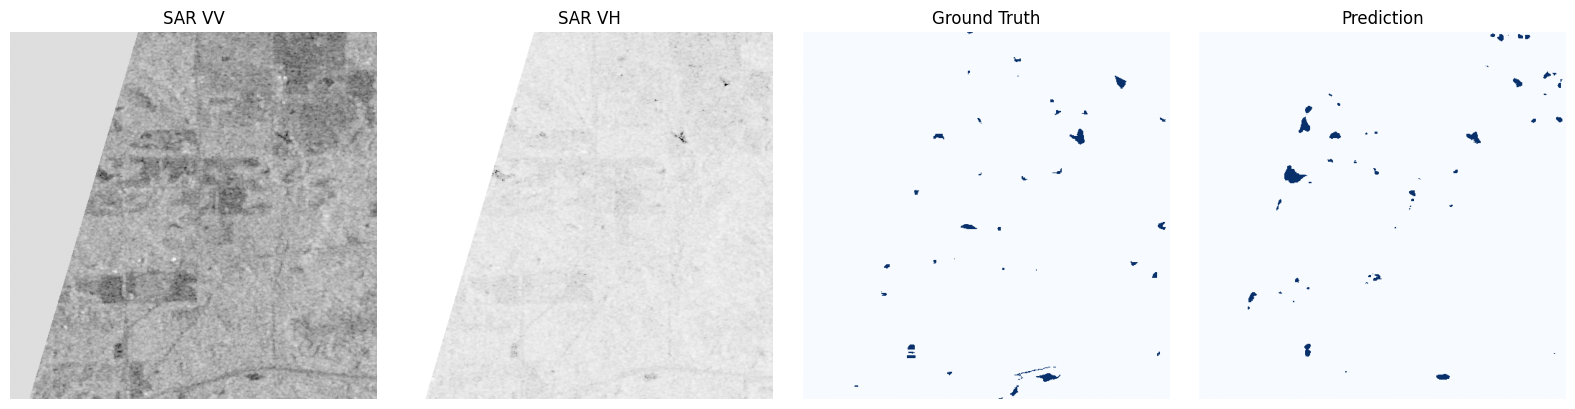

In [19]:
# Show example predictions before downstream tasks:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    x, y, valid = next(iter(test_dl))
    x, y = x.to(device), y.to(device)
    logits = model(x)
    preds = (torch.sigmoid(logits) > 0.5).float()

# Visualize first sample
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(x[0, 0].cpu(), cmap='gray')
axes[0].set_title('SAR VV')
axes[1].imshow(x[0, 1].cpu(), cmap='gray')
axes[1].set_title('SAR VH')
axes[2].imshow(y[0, 0].cpu(), cmap='Blues')
axes[2].set_title('Ground Truth')
axes[3].imshow(preds[0, 0].cpu(), cmap='Blues')
axes[3].set_title('Prediction')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.savefig('segmentation_results.png', dpi=150)
plt.show()

Reusable embedding

In [20]:
def extract_embedding(model, x_batch):
    """
    Extracts a reusable embedding from the deepest encoder feature map.
    Args:
        model: Trained segmentation model
        x_batch: (B, 2, H, W) - batch of SAR images

    Returns:
        pooled: (B, C) - fixed-size embedding per image
    """
    model.eval()
    with torch.no_grad():
        # SMP encoders return a list of feature maps → take deepest one
        feat_list = model.encoder(x_batch)      # list of tensors
        feats = feat_list[-1]                   # (B, C, H', W')

        # Global average pooling over spatial dims
        pooled = feats.mean(dim=(2, 3))         # (B, C)
    return pooled

We could use it standalone. The `embedding` variable will contain a 512-dimensional feature vector that represents the SAR image in a compressed, learned feature space.

In [21]:
# Extract embedding for a single new SAR image
single_image = torch.randn(1, 2, 512, 512).to(device)
embedding = extract_embedding(model, single_image)  # (1, 512)

print(embedding.shape)
print(type(embedding))

torch.Size([1, 512])
<class 'torch.Tensor'>


Example: does this chip contain any flooded pixels?


In [22]:
def compute_embeddings(dataloader, model, device="cuda"):
    """
    Returns:
      Z: (N, C) numpy array of embeddings
      Y: (N,) numpy array of chip-level labels (0/1)
    """
    all_z = []
    all_y = []

    model.eval()
    with torch.no_grad():
        for x, y, valid in dataloader:
            x = x.to(device)
            y = y.to(device)

            # 1) Compute embeddings
            z = extract_embedding(model, x)  # (B, C)
            all_z.append(z.cpu().numpy())

            # 2) Create simple chip-level label:
            #    1 if any flood pixel exists, else 0
            #    (you can refine this, e.g. >1% flood coverage)
            y_flat = y.view(y.size(0), -1)
            chip_label = (y_flat.max(dim=1).values > 0.5).float()
            all_y.append(chip_label.cpu().numpy())

    Z = np.concatenate(all_z, axis=0)
    Y = np.concatenate(all_y, axis=0)
    return Z, Y

In [23]:
Z_train, Y_train = compute_embeddings(train_dl, model, device=device)
Z_val,   Y_val   = compute_embeddings(val_dl,   model, device=device)
Z_test,  Y_test  = compute_embeddings(test_dl,  model, device=device)

print(Z_train.shape, Y_train.shape)

(105, 512) (105,)


In [24]:
# ========================================
# SAVE EMBEDDINGS LOCALLY (Download to Computer)
# ========================================

import numpy as np
from google.colab import files

# Save embeddings
np.savez('sar_embeddings.npz',
         Z_train=Z_train, Y_train=Y_train,
         Z_val=Z_val, Y_val=Y_val,
         Z_test=Z_test, Y_test=Y_test)

print("✅ Embeddings saved to: sar_embeddings.npz")

# Download to your computer
print("⬇️ Downloading to your computer...")
files.download('sar_embeddings.npz')

print("✅ Download complete! Check your Downloads folder.")

✅ Embeddings saved to: sar_embeddings.npz
⬇️ Downloading to your computer...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download complete! Check your Downloads folder.


Downstream task: chip-level classification

We use `Z_train` which is an embedding matrix of shape (47. 512), with each row representing 512-dimensional feature vector produced by the encoder.

`Y_train` is the labels, each label = 0 (no flood) or 1 (flood exists somewhere in the chip)

### DOWNSTREAM TASK 1: Flood Detection Classification


Test Set Performance:
  Accuracy: 0.8696
  F1-Score: 0.9302

Classification Report:
              precision    recall  f1-score   support

    No Flood       0.00      0.00      0.00         1
       Flood       0.95      0.91      0.93        22

    accuracy                           0.87        23
   macro avg       0.48      0.45      0.47        23
weighted avg       0.91      0.87      0.89        23



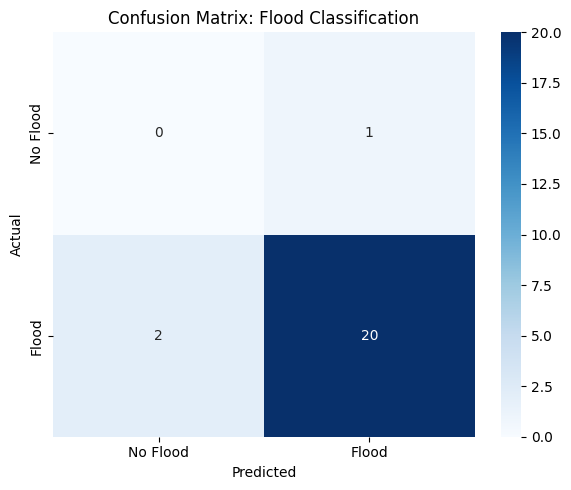

Saved: classification_confusion_matrix.png


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

# Train classifier on embeddings
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(Z_train, Y_train)

# Predict on test set
Y_pred_test = clf.predict(Z_test)

print(f"\nTest Set Performance:")
print(f"  Accuracy: {accuracy_score(Y_test, Y_pred_test):.4f}")

# Only compute F1 if both classes exist in predictions
if len(np.unique(Y_pred_test)) > 1:
    print(f"  F1-Score: {f1_score(Y_test, Y_pred_test):.4f}")
else:
    print(f"  F1-Score: N/A (model only predicts one class)")

print("\nClassification Report:")
print(classification_report(Y_test, Y_pred_test,
                          target_names=['No Flood', 'Flood'],
                          zero_division=0))

# Confusion matrix
cm = confusion_matrix(Y_test, Y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Flood', 'Flood'],
            yticklabels=['No Flood', 'Flood'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Flood Classification')
plt.tight_layout()
plt.savefig('classification_confusion_matrix.png', dpi=150)
plt.show()

print("Saved: classification_confusion_matrix.png")

###DOWNSTREAM TASK 2: Image Similarity Search


Query: USA_347609
  Flood label: Yes

Top 5 most similar training images:
  1. USA_366607 - Similarity: 1490.4053, Flood: No
  2. Paraguay_24341 - Similarity: 1465.0704, Flood: Yes
  3. Paraguay_40936 - Similarity: 1411.4689, Flood: Yes
  4. India_244057 - Similarity: 1346.3229, Flood: Yes
  5. USA_595451 - Similarity: 1291.2515, Flood: Yes


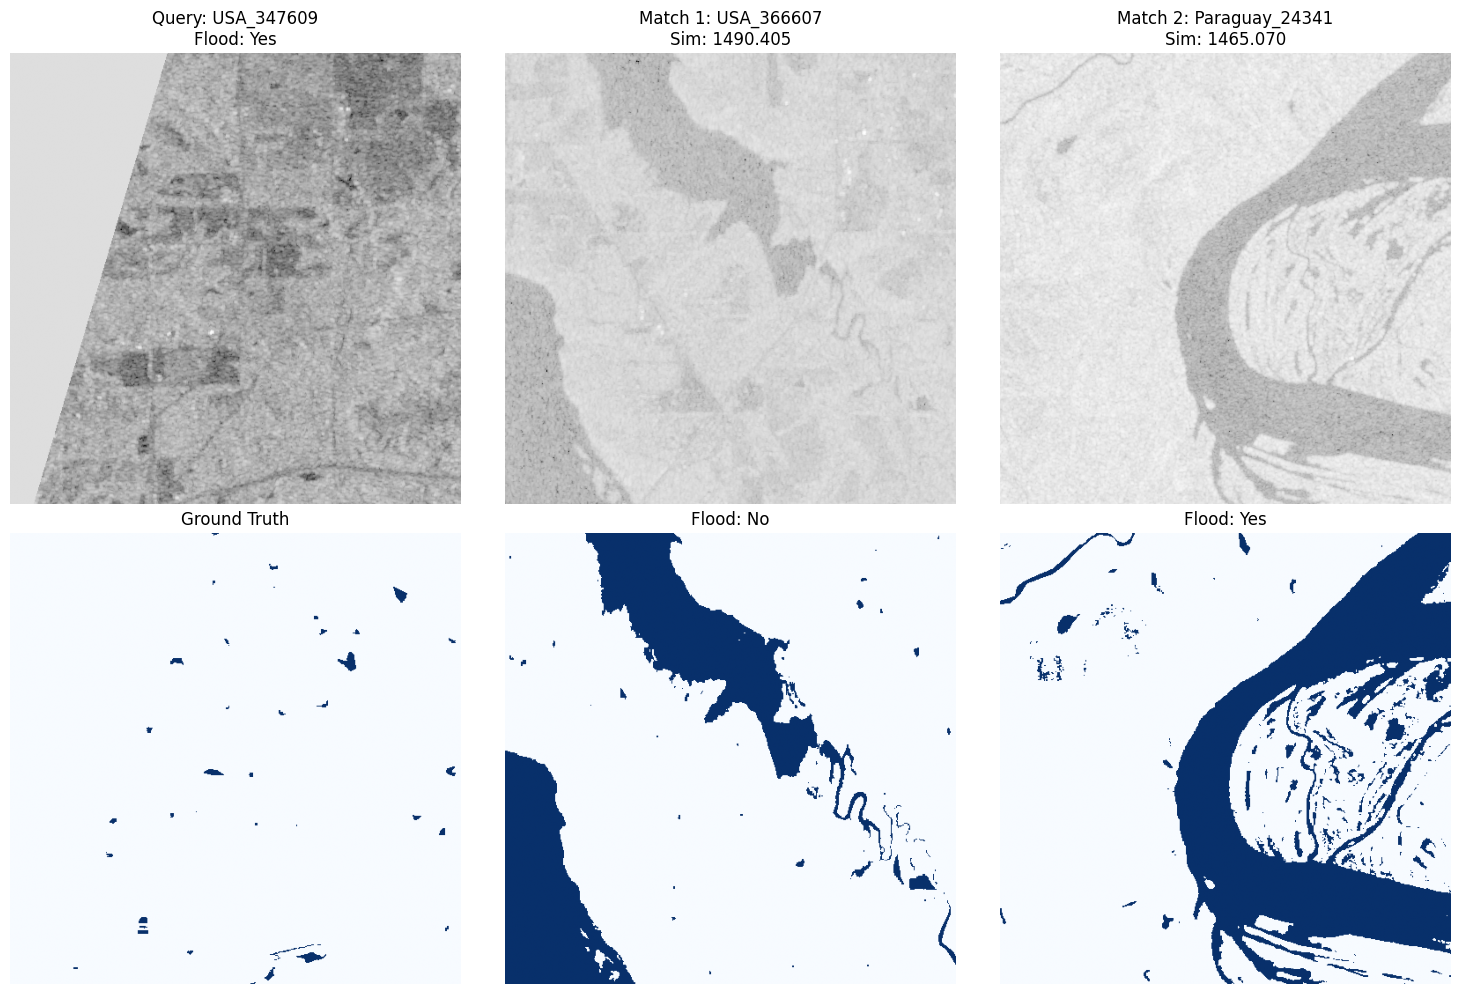

Saved: similarity_search_results.png


In [26]:
# Pick a query image from test set
query_idx = 0
query_chip_id = test_ids[query_idx]

# Get its embedding
model.eval()
with torch.no_grad():
    x_query, y_query, valid_query = test_ds[query_idx]
    x_query = x_query.unsqueeze(0).to(device)
    embedding_query = extract_embedding(model, x_query)

# Compute similarity to all training images
embedding_query_np = embedding_query.cpu().numpy()
similarities = np.dot(Z_train, embedding_query_np.T).flatten()  # Cosine similarity
top_k = 5
top_indices = similarities.argsort()[-top_k:][::-1]

print(f"\nQuery: {query_chip_id}")
print(f"  Flood label: {'Yes' if Y_test[query_idx] == 1 else 'No'}")
print(f"\nTop {top_k} most similar training images:")
for rank, idx in enumerate(top_indices, 1):
    print(f"  {rank}. {train_ids[idx]} - Similarity: {similarities[idx]:.4f}, Flood: {'Yes' if Y_train[idx] == 1 else 'No'}")

# Visualize query and top matches
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Query image
x_q, y_q, _ = test_ds[query_idx]
axes[0, 0].imshow(x_q[0].cpu(), cmap='gray')
axes[0, 0].set_title(f'Query: {query_chip_id}\nFlood: {"Yes" if Y_test[query_idx] == 1 else "No"}')
axes[0, 0].axis('off')

axes[1, 0].imshow(y_q[0].cpu(), cmap='Blues')
axes[1, 0].set_title('Ground Truth')
axes[1, 0].axis('off')

# Top 2 similar images
for i, idx in enumerate(top_indices[:2], 1):
    x_similar, y_similar, _ = train_ds[idx]

    axes[0, i].imshow(x_similar[0].cpu(), cmap='gray')
    axes[0, i].set_title(f'Match {i}: {train_ids[idx]}\nSim: {similarities[idx]:.3f}')
    axes[0, i].axis('off')

    axes[1, i].imshow(y_similar[0].cpu(), cmap='Blues')
    axes[1, i].set_title(f'Flood: {"Yes" if Y_train[idx] == 1 else "No"}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('similarity_search_results.png', dpi=150)
plt.show()

print("Saved: similarity_search_results.png")

###DOWNSTREAM TASK 3: Clustering Analysis

Silhouette Score: 0.2315

Cluster distribution (test set):
  Cluster 0: 4 samples, 3 floods (75.0%)
  Cluster 1: 9 samples, 9 floods (100.0%)
  Cluster 2: 10 samples, 10 floods (100.0%)


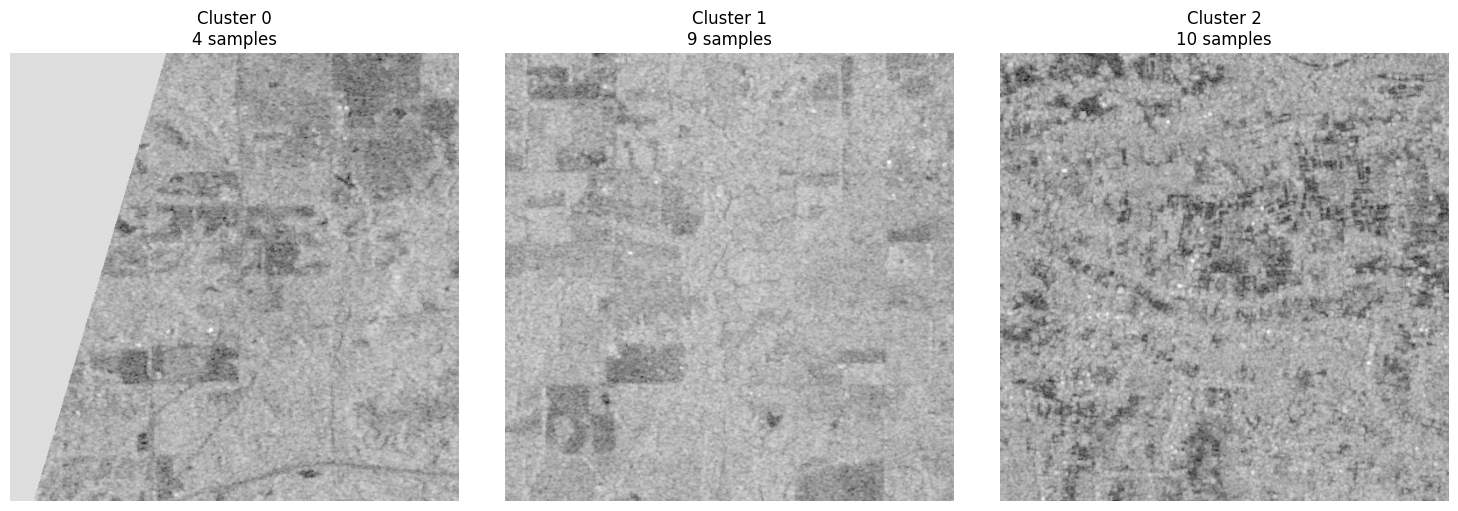

Saved: clustering_examples.png


In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Cluster embeddings to discover flood patterns
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters_train = kmeans.fit_predict(Z_train)
clusters_test = kmeans.predict(Z_test)

sil_score = silhouette_score(Z_test, clusters_test)
print(f"Silhouette Score: {sil_score:.4f}")

print(f"\nCluster distribution (test set):")
for i in range(n_clusters):
    cluster_mask = clusters_test == i
    n_samples = cluster_mask.sum()
    n_floods = Y_test[cluster_mask].sum()
    print(f"  Cluster {i}: {n_samples} samples, {n_floods:.0f} floods ({100*n_floods/n_samples:.1f}%)")

# Visualize clusters
fig, axes = plt.subplots(1, n_clusters, figsize=(15, 5))

for cluster_id in range(n_clusters):
    # Find test samples in this cluster
    cluster_mask = clusters_test == cluster_id
    cluster_indices = np.where(cluster_mask)[0]

    if len(cluster_indices) > 0:
        # Show first sample from this cluster
        sample_idx = cluster_indices[0]
        x_sample, y_sample, _ = test_ds[sample_idx]

        axes[cluster_id].imshow(x_sample[0].cpu(), cmap='gray')
        axes[cluster_id].set_title(f'Cluster {cluster_id}\n{cluster_mask.sum()} samples')
        axes[cluster_id].axis('off')

plt.tight_layout()
plt.savefig('clustering_examples.png', dpi=150)
plt.show()

print("Saved: clustering_examples.png")

###DOWNSTREAM TASK 4: Compare Two Specific Images


Comparing two SAR images:
  Image A: USA_347609 - Flood: Yes
  Image B: India_287642 - Flood: Yes
  Cosine Similarity: 0.5841
  → Moderately similar images


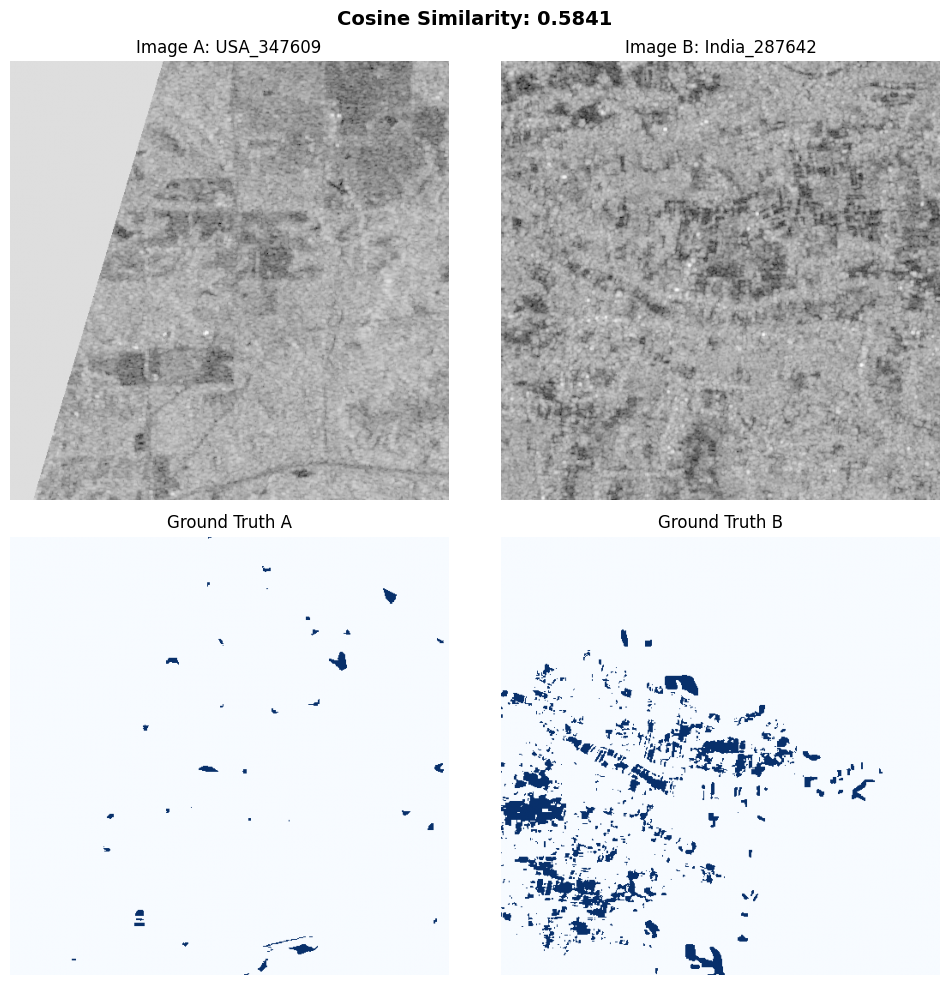

Saved: pairwise_comparison.png


In [28]:
# Compare two test images
idx_A, idx_B = 0, 1

model.eval()
with torch.no_grad():
    x_A, y_A, _ = test_ds[idx_A]
    x_B, y_B, _ = test_ds[idx_B]

    x_A_batch = x_A.unsqueeze(0).to(device)
    x_B_batch = x_B.unsqueeze(0).to(device)

    embedding_A = extract_embedding(model, x_A_batch)
    embedding_B = extract_embedding(model, x_B_batch)

    similarity = torch.cosine_similarity(embedding_A, embedding_B, dim=1).item()

print(f"\nComparing two SAR images:")
print(f"  Image A: {test_ids[idx_A]} - Flood: {'Yes' if Y_test[idx_A] == 1 else 'No'}")
print(f"  Image B: {test_ids[idx_B]} - Flood: {'Yes' if Y_test[idx_B] == 1 else 'No'}")
print(f"  Cosine Similarity: {similarity:.4f}")

if similarity > 0.8:
    print("  → Very similar images (likely same region/conditions)")
elif similarity > 0.5:
    print("  → Moderately similar images")
else:
    print("  → Different images (different regions/flood patterns)")

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(x_A[0].cpu(), cmap='gray')
axes[0, 0].set_title(f'Image A: {test_ids[idx_A]}')
axes[0, 0].axis('off')

axes[0, 1].imshow(x_B[0].cpu(), cmap='gray')
axes[0, 1].set_title(f'Image B: {test_ids[idx_B]}')
axes[0, 1].axis('off')

axes[1, 0].imshow(y_A[0].cpu(), cmap='Blues')
axes[1, 0].set_title(f'Ground Truth A')
axes[1, 0].axis('off')

axes[1, 1].imshow(y_B[0].cpu(), cmap='Blues')
axes[1, 1].set_title(f'Ground Truth B')
axes[1, 1].axis('off')

fig.suptitle(f'Cosine Similarity: {similarity:.4f}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('pairwise_comparison.png', dpi=150)
plt.show()

print("Saved: pairwise_comparison.png")